# Regresja liniowa, Ridge i Lasso

## a) Przykład równania regresji i predykcji

Rozważmy regresję liniową z dwiema zmiennymi objaśniającymi:

$$
\hat y = \beta_0 + \beta_1 x_1 + \beta_2 x_2
$$

Przykładowo (czysto ilustracyjnie), jeśli zmienne są funkcjami cosinus:

$$
\hat y = \beta_0 + \beta_1 \cos(x_1) + \beta_2 \cos(x_2)
$$

Dla przykładowych współczynników:
- $$\beta_0 = 1.0$$
- $$\beta_1 = 0.5$$
- $$\beta_2 = -0.3$$

oraz danych:
- $$x_1 = 0$$
- $$x_2 = \pi / 2$$

predykcja $$\hat y$$ jest liczona przez bezpośrednie podstawienie do wzoru.

---

## b) Funkcja straty – wersja podstawowa

W regresji liniowej chcemy, aby predykcja $$\hat y$$ była jak najbliżej wartości rzeczywistej $$y$$.

Najprostsza intuicyjna strata to różnica:

$$
(y - \hat y)
$$

W praktyce różnicę tę podnosi się do kwadratu i sumuje po wszystkich obserwacjach.

Ważne jest, aby pamiętać, że:

$$
\hat y = \beta_0 + \beta_1 x_1 + \beta_2 x_2
$$

---

## c) Funkcja straty Ridge (L2)

W regresji Ridge do klasycznej straty dodajemy karę za duże wartości współczynników:

$$
RSS_{L2} =
\sum_{i=1}^{n} (y_i - \hat y_i)^2
+
\lambda \sum_{j=1}^{p} \beta_j^2
$$

Kara L2 powoduje, że:
- duże współczynniki są silnie tłumione,
- bardzo małe współczynniki (dużo mniejsze od 1) są karane słabo.

---

## d) Funkcja straty Lasso (L1)

W regresji Lasso stosuje się inną postać kary:

$$
RSS_{L1} =
\sum_{i=1}^{n} (y_i - \hat y_i)^2
+
\lambda \sum_{j=1}^{p} |\beta_j|
$$

Kara L1 (wartość bezwzględna):
- silnie karze nawet bardzo małe w

**W skrócie:** Lasso sprzyja selekcji zmiennych, a Ridge stabilizacji współczynników.


**W skrócie:** Lasso sprzyja selekcji zmiennych, a Ridge stabilizacji współczynników.
**W skrócie:**  
Lasso sprzyja selekcji zmiennych, a Ridge stabilizacji współczynników.


## e) Porównanie Ridge i Lasso – intuicja

- **Lasso** mocno karze małe współczynniki kierunkowe, co sprzyja ich wyzerowaniu (selekcja zmiennych).
- **Ridge** jest łagodny dla bardzo małych współczynników (≪ 1), ale coraz silniej karze współczynniki duże.
- Różnica ta wynika bezpośrednio z postaci kary: $$\beta^2$$ (Ridge) vs $$|\beta|$$ (Lasso).

**W skrócie:** Lasso sprzyja selekcji zmiennych, a Ridge stabilizacji współczynników.

In [136]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import iqr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance

In [53]:
# =========================
# Core libraries
# =========================
import numpy as np
import pandas as pd

# =========================
# Visualization (optional but common)
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Scikit-learn: data & utilities
# =========================
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# =========================
# Scikit-learn: regression models
# =========================
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# =========================

# =========================


# =========================
# Scikit-learn: metrics
# =========================
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================
# Load California Housing dataset
# =========================
california = fetch_california_housing(as_frame=True)

X = california.data
y = california.target

df = X.copy()
df["target"] = y

# Dataset description (string)
dataset_description = california.DESCR

# Quick sanity check
df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [54]:
print(dataset_description)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [56]:
for c in df.columns :
    print(c, '\n' * 2, df[c].sample(n = 10), '\n')

MedInc 

 2181     3.6204
7512     2.4271
18893    3.2664
10375    7.7814
17373    4.8155
1403     4.8702
8904     4.5160
13110    4.8831
14552    6.4696
5286     4.6197
Name: MedInc, dtype: float64 

HouseAge 

 902      28.0
14371    32.0
202      43.0
18194    32.0
5608      8.0
1415     29.0
14643    34.0
16622    21.0
17407    24.0
14892    27.0
Name: HouseAge, dtype: float64 

AveRooms 

 18715     5.950450
15687     4.184272
13797     4.575758
4328      3.856774
596       6.629268
2692      6.640449
20089    10.845815
8586      6.008357
16334     6.570292
10014     7.129436
Name: AveRooms, dtype: float64 

AveBedrms 

 17999    0.920091
19615    1.346939
11319    1.036364
7595     1.082524
5564     1.131915
19800    2.561404
5666     1.091589
1091     0.889680
19781    2.415385
8707     1.099688
Name: AveBedrms, dtype: float64 

Population 

 7099     3836.0
13613    1291.0
7439     1559.0
11158    1536.0
1612      680.0
11488    3079.0
10821    1198.0
16019     762.0
16304    1

In [57]:
statystyki_opisowe = df.describe().round(2)
statystyki_opisowe

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00
mean,3.87,28.64,5.43,1.10,1425.48,3.07,35.63,-119.57,2.07
std,1.90,12.59,2.47,0.47,1132.46,10.39,2.14,2.00,1.15
min,0.50,1.00,0.85,0.33,3.00,0.69,32.54,-124.35,0.15
25%,2.56,18.00,4.44,1.01,787.00,2.43,33.93,-121.80,1.20
50%,3.53,29.00,5.23,1.05,1166.00,2.82,34.26,-118.49,1.80
75%,4.74,37.00,6.05,1.10,1725.00,3.28,37.71,-118.01,2.65
max,15.00,52.00,141.91,34.07,35682.00,1243.33,41.95,-114.31,5.00


In [58]:
statystyki_opisowe.loc[['mean', '50%', 'min', 'max'], : ]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
mean,3.87,28.64,5.43,1.10,1425.48,3.07,35.63,-119.57,2.07
50%,3.53,29.00,5.23,1.05,1166.00,2.82,34.26,-118.49,1.80
min,0.50,1.00,0.85,0.33,3.00,0.69,32.54,-124.35,0.15
max,15.00,52.00,141.91,34.07,35682.00,1243.33,41.95,-114.31,5.00


In [59]:
df[df.duplicated()]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target


## Badamy rozkład zmiennej którą przewidujemy

In [60]:
df.target.sum()

42695.04061

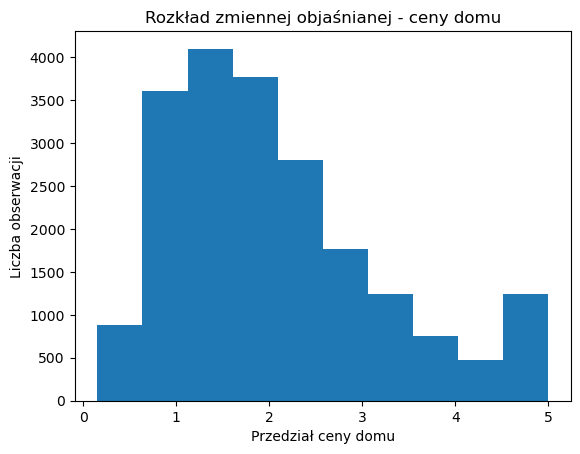

In [61]:
df.target.plot.hist()
plt.title('Rozkład zmiennej objaśnianej - ceny domu')
plt.ylabel('Liczba obserwacji')
plt.xlabel('Przedział ceny domu')
plt.show()

## Naiwna, baseline predykcja

Kiedy dostaniemy wynik modelu, musimy to z czymś porównać. Na pewno chcemy model, który jest lepszy od mówienia zawsze, że cena domu będzie taka, jak średnia cen domu w przeszłości.

In [62]:
df['target'].mean()

2.0685581690891843

In [63]:
naiwna_predykcja_srednia = df.target.median()
naiwna_predykcja_srednia

1.797

In [64]:
range(3)

range(0, 3)

In [65]:
for i in range(3) :
    print( i )

0
1
2


In [66]:
liczby = [ i for i in range(3) ]
liczby

[0, 1, 2]

In [67]:
for i in range(len(liczby)) :
    print( 'hi' )

hi
hi
hi


In [68]:
naiwne_predykcje = [ naiwna_predykcja_srednia for i in range(len(df)) ]
naiwne_predykcje[ : 10]

[1.797, 1.797, 1.797, 1.797, 1.797, 1.797, 1.797, 1.797, 1.797, 1.797]

## Oczekujemy, że nasz model będzie miał lepszą wartość metryki

In [69]:
mean_absolute_error( df.target, naiwne_predykcje)

0.8835413124999999

In [70]:
# =========================
# Train-test split (default setup)
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [71]:
y_train.sum() + y_test.sum()

42695.04061

In [72]:
trainset.MedHouseVal.sum() + testset.MedHouseVal.sum()

137.059

In [73]:
X_train.head(2)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14196,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03
8267,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16


In [74]:
trainset = pd.concat( [X_train, y_train], axis = 1)
testset = pd.concat( [X_test, y_test], axis = 1)

trainset.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
14196,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03,1.030
8267,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16,3.821
17445,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48,1.726
14265,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11,0.934
2271,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80,0.965


In [75]:
trainset.corr().round(2)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,1.00,-0.12,0.34,-0.07,0.00,0.02,-0.08,-0.02,0.69
HouseAge,-0.12,1.00,-0.16,-0.09,-0.29,0.02,0.01,-0.10,0.10
AveRooms,0.34,-0.16,1.00,0.84,-0.07,-0.00,0.11,-0.03,0.16
AveBedrms,-0.07,-0.09,0.84,1.00,-0.07,-0.01,0.07,0.02,-0.05
Population,0.00,-0.29,-0.07,-0.07,1.00,0.07,-0.10,0.09,-0.03
AveOccup,0.02,0.02,-0.00,-0.01,0.07,1.00,0.01,-0.00,-0.02
Latitude,-0.08,0.01,0.11,0.07,-0.10,0.01,1.00,-0.92,-0.14
Longitude,-0.02,-0.10,-0.03,0.02,0.09,-0.00,-0.92,1.00,-0.05
MedHouseVal,0.69,0.10,0.16,-0.05,-0.03,-0.02,-0.14,-0.05,1.00


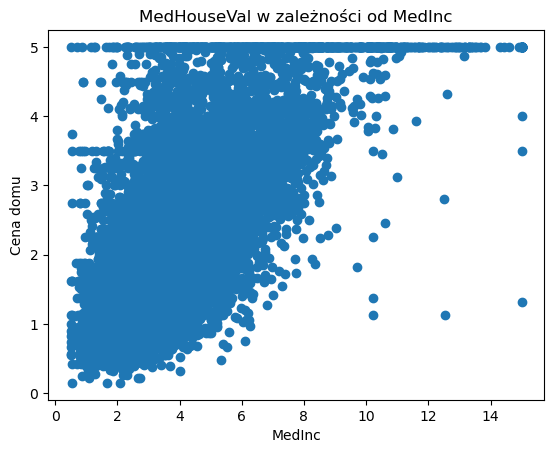

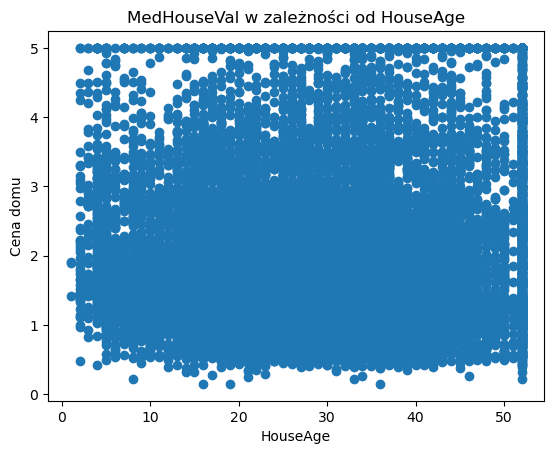

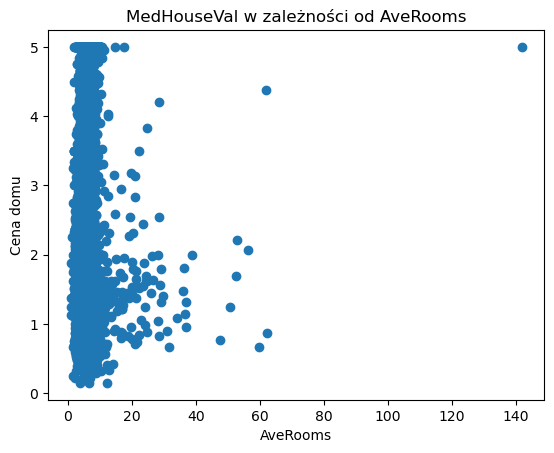

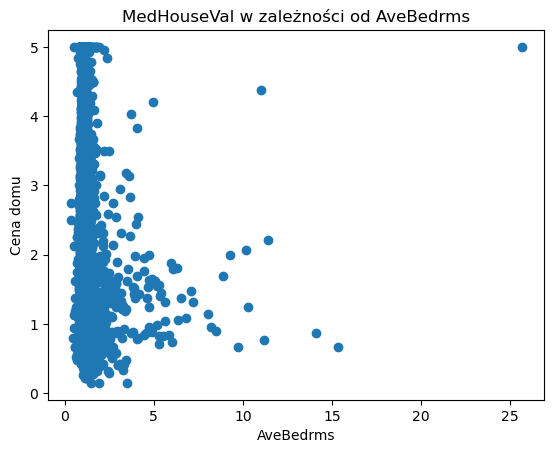

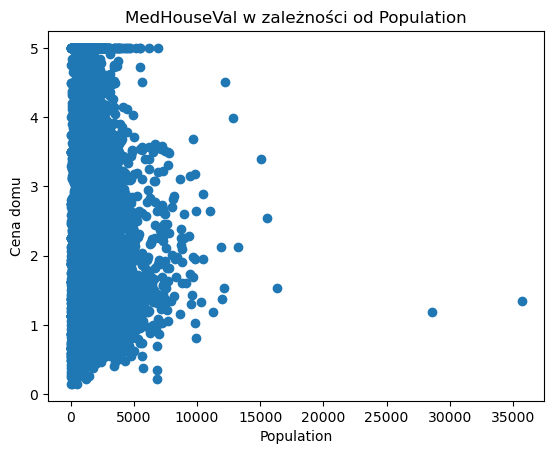

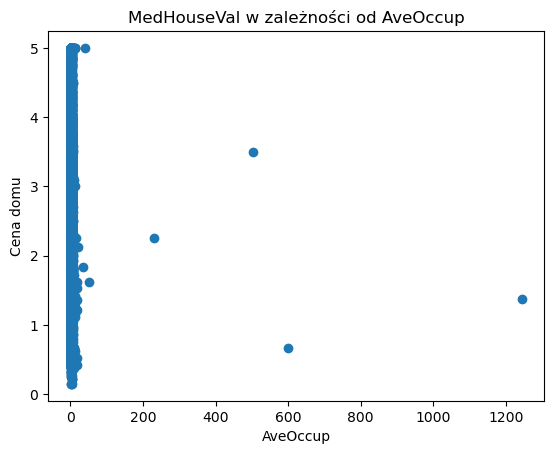

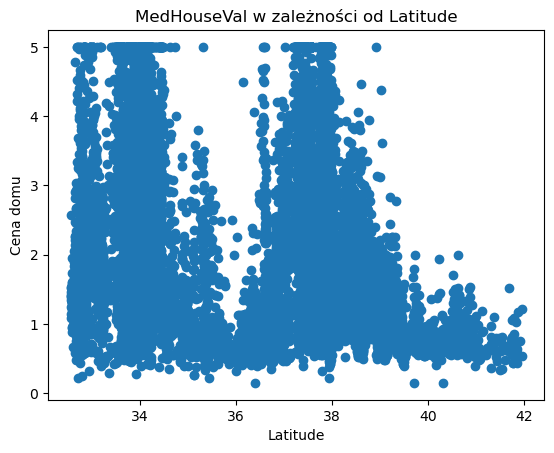

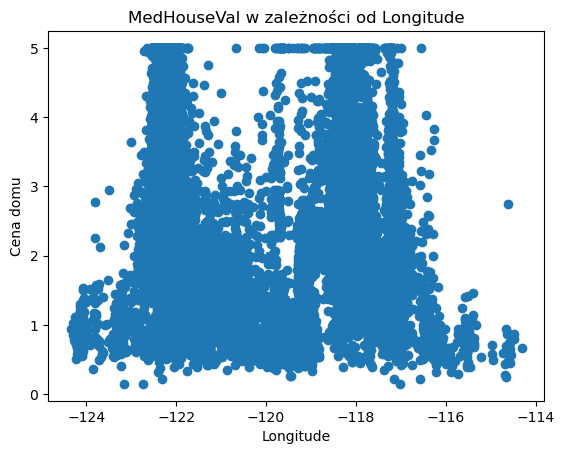

In [76]:
for c in trainset.columns :
    if c != 'MedHouseVal' :
        print()
        plt.scatter( trainset[c], trainset['MedHouseVal'] )
        plt.title("MedHouseVal w zależności od {}".format(c))
        plt.ylabel('Cena domu')
        plt.xlabel(c)
        plt.show()
        print()

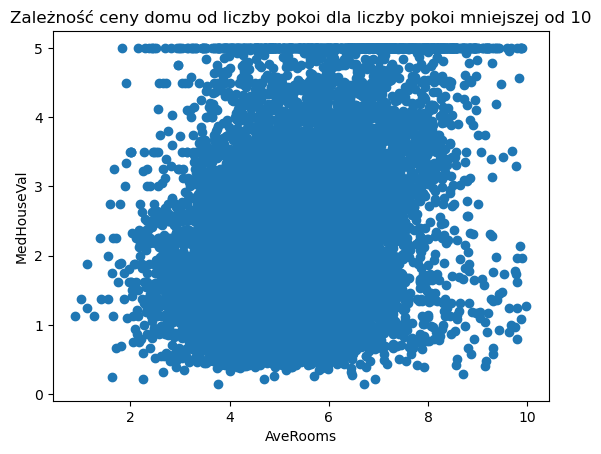

In [77]:
malo_pokoi = trainset[ trainset['AveRooms'] < 10 ]
malo_pokoi.shape

plt.scatter( malo_pokoi['AveRooms'], malo_pokoi['MedHouseVal'] )
plt.ylabel('MedHouseVal')
plt.xlabel('AveRooms')
plt.title('Zależność ceny domu od liczby pokoi dla liczby pokoi mniejszej od 10')
plt.show()

## Analiza obserwacji odstajacych numerycznie od pozostalych

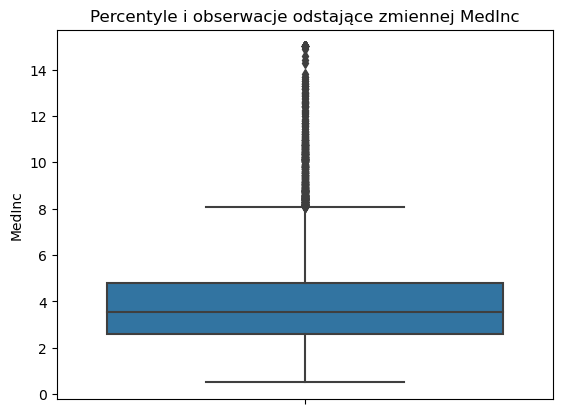

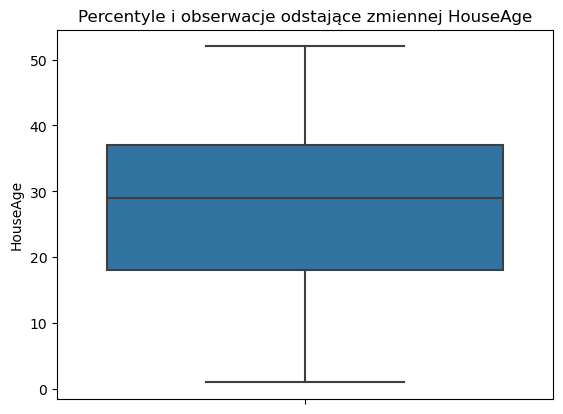

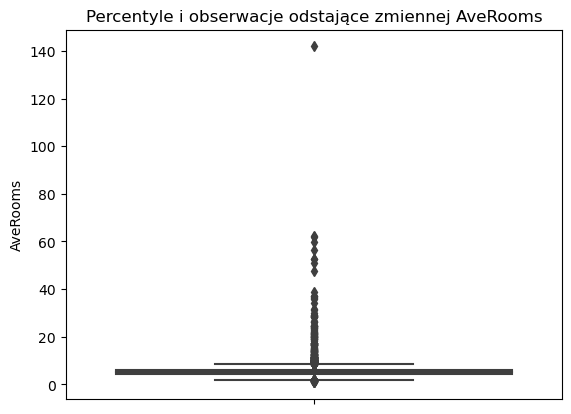

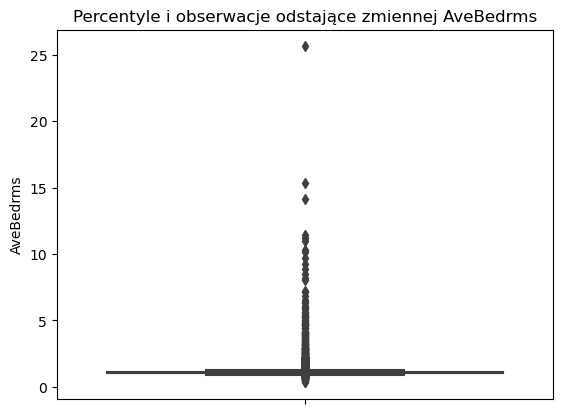

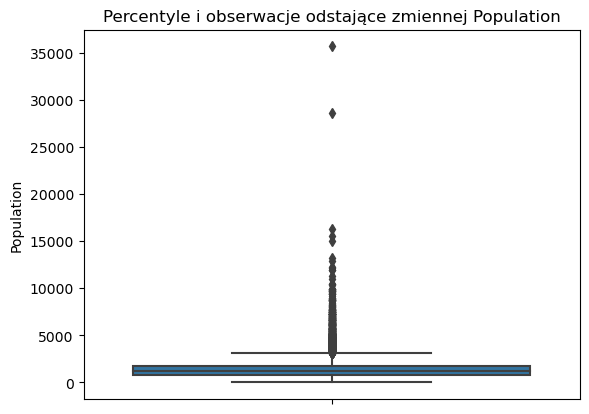

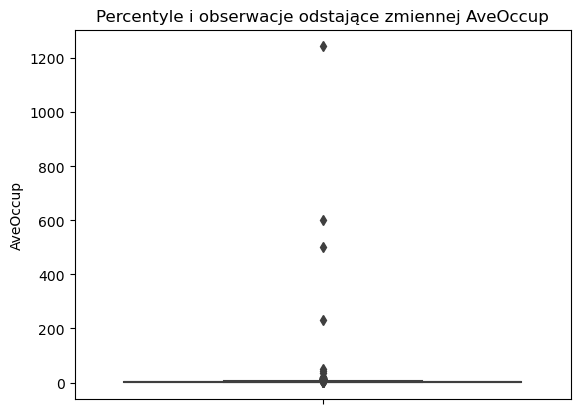

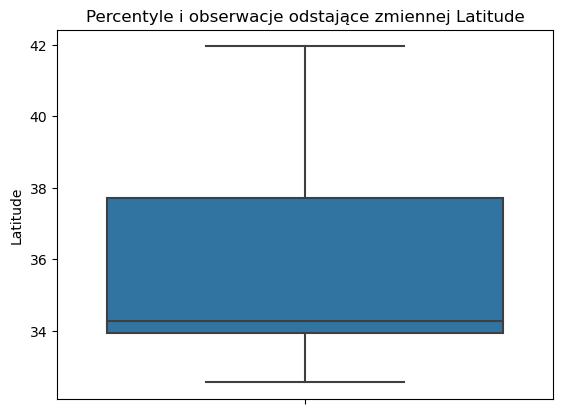

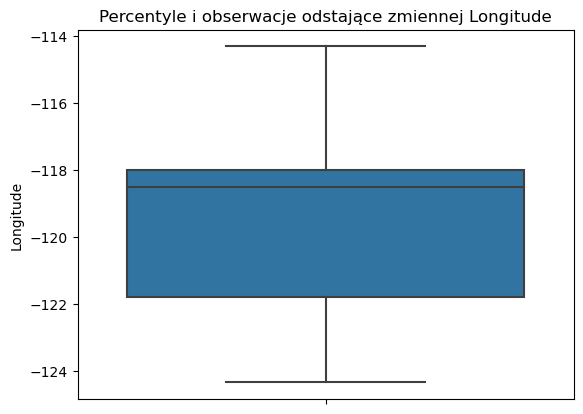

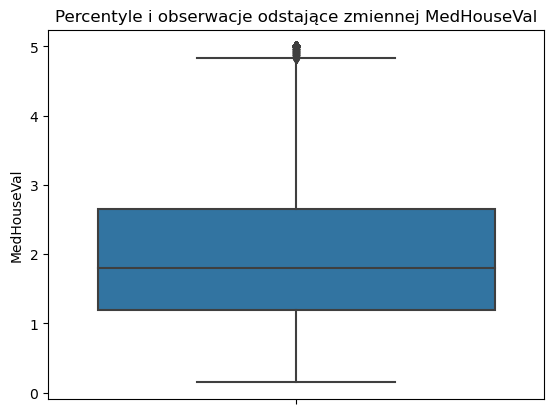

In [78]:
for c in trainset.columns :
    print()
    sns.boxplot(y = c, data = trainset)
    plt.title("Percentyle i obserwacje odstające zmiennej {}".format(c))
    plt.ylabel(c)
    plt.show()
    print()

## Wyliczamy progi liczb do wykluczenia z danych do modelowania

In [79]:
progi_duzych_liczby_wg_kolumn = {}
progi_malych_liczby_wg_kolumn = {}

for c in trainset.columns :
    poltora_iqr = 1.5 * iqr( trainset[c] )
    # czyli dolna krawedz pudelka na boxplot (wyrkes ramka-wasy)
    dolny_kwartyl = np.percentile( trainset[c], 0.25 )

    # czyli gorna krawedz pudelka na boxplot (wyrkes ramka-wasy)
    gorny_kwartyl = np.percentile( trainset[c], 0.75 )

    # liczby ktore sa za duze
    gorny_prog = gorny_kwartyl + poltora_iqr

    # liczby ktore sa za male
    dolny_prog = dolny_kwartyl - poltora_iqr
    
    progi_duzych_liczby_wg_kolumn[c] = gorny_prog

    progi_malych_liczby_wg_kolumn[c] = dolny_prog



progi_duzych_liczby_wg_kolumn

{'MedInc': 4.3088415,
 'HouseAge': 32.5,
 'AveRooms': 4.881911951206414,
 'AveBedrms': 0.9964300304163718,
 'Population': 1471.3325,
 'AveOccup': 2.7822601770383537,
 'Latitude': 38.345,
 'Longitude': -118.041675,
 'MedHouseVal': 2.662875}

In [80]:
for c in trainset.columns :
    # usuwamy za duze liczby ze zbioru treningowego
    trainset = trainset[ trainset[c] < progi_duzych_liczby_wg_kolumn[c]  ]

    # usuwamy za duze liczby ze zbioru testowego wg tych samych progow
    testset = testset[ testset[c] < progi_duzych_liczby_wg_kolumn[c]  ]

    # usuwamy za male liczby ze zbioru treningowego
    trainset = trainset[ trainset[c] > progi_malych_liczby_wg_kolumn[c]  ]

    # usuwamy za male liczby ze zbioru testowego wg tych samych progow
    testset = testset[ testset[c] > progi_malych_liczby_wg_kolumn[c]  ]
    

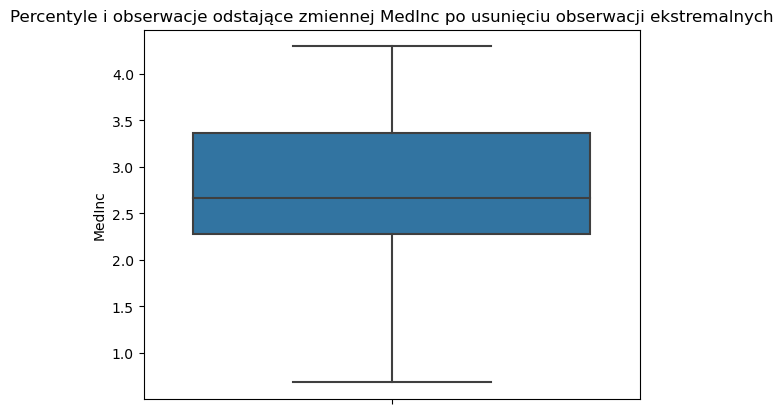

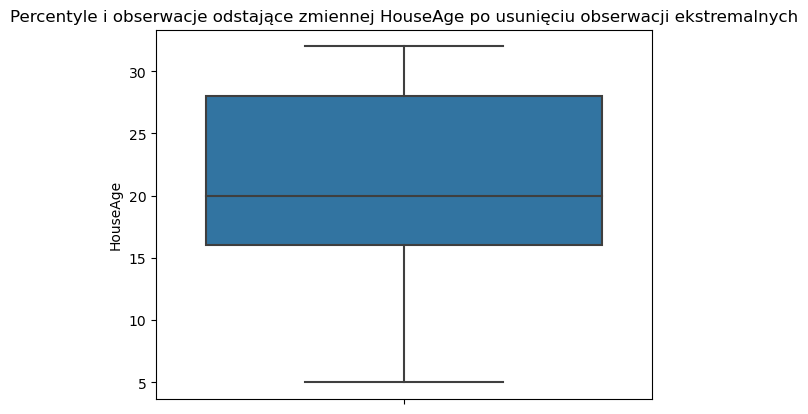

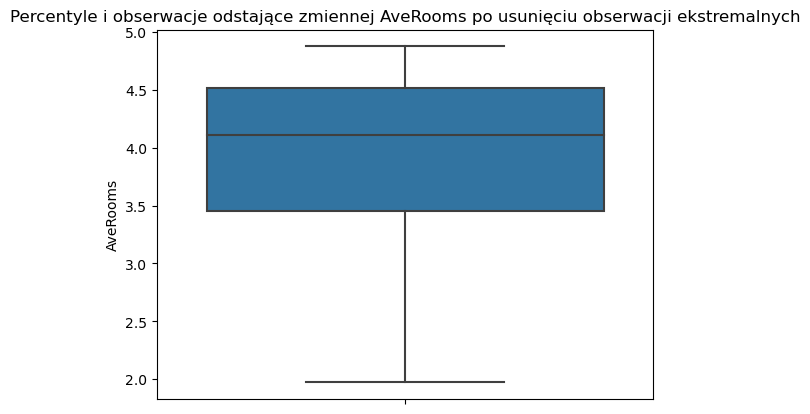

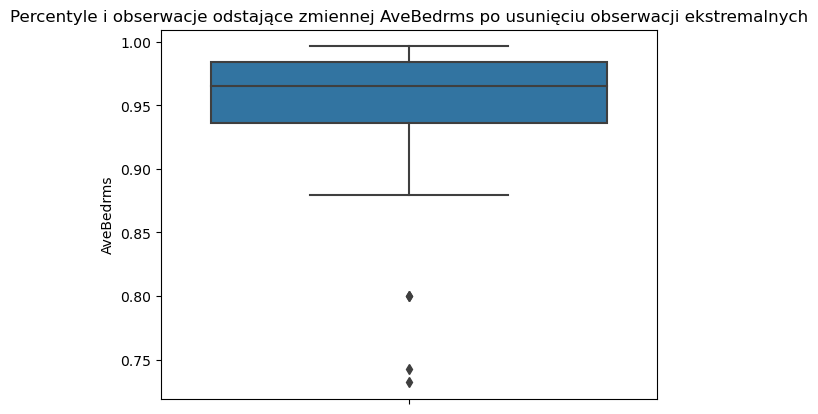

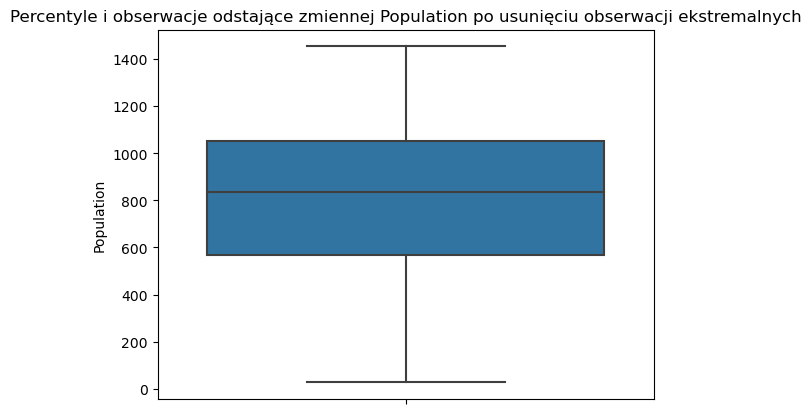

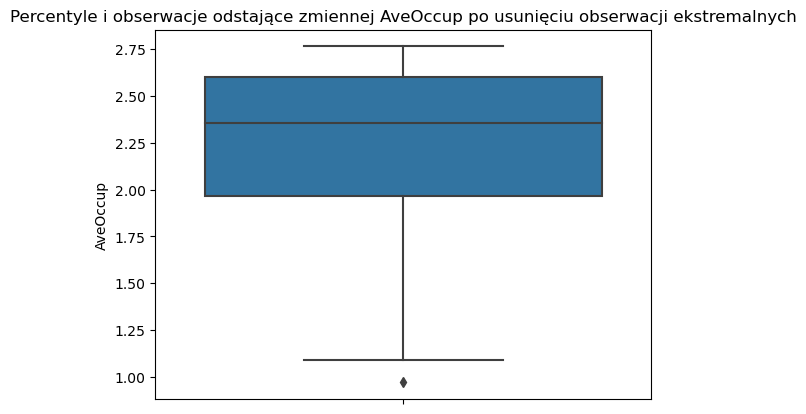

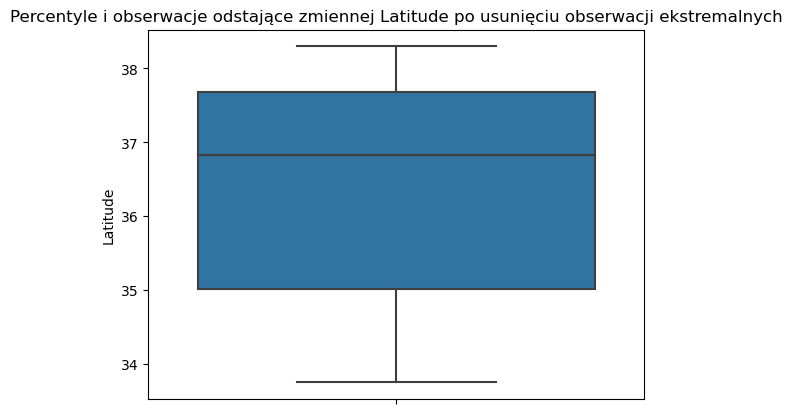

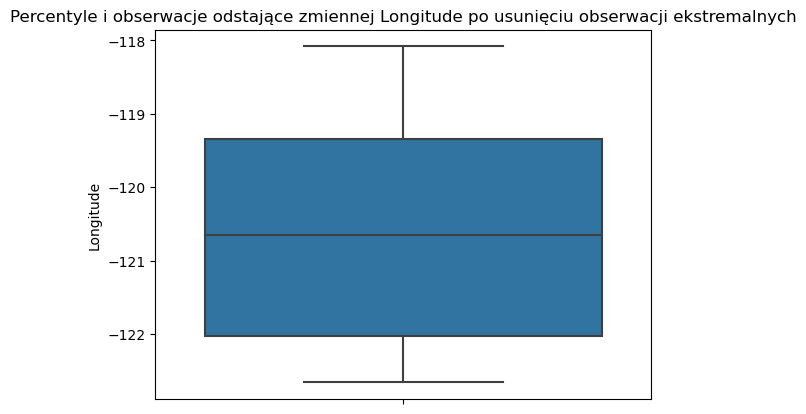

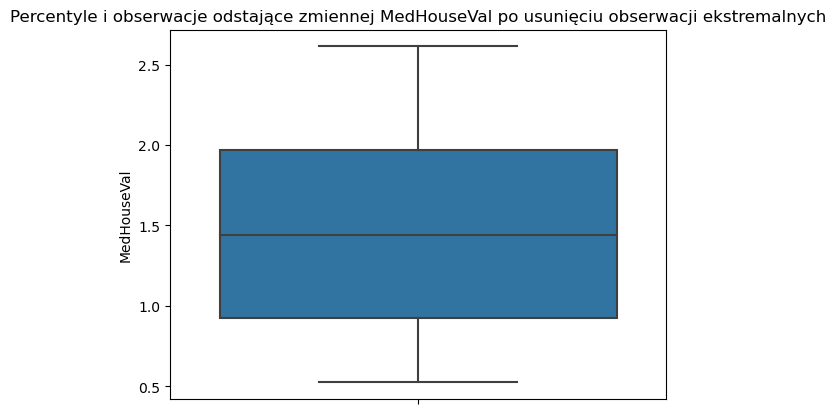

In [81]:
for c in trainset.columns :
    print()
    sns.boxplot(y = c, data = trainset)
    plt.title("Percentyle i obserwacje odstające zmiennej {} po usunięciu obserwacji ekstremalnych".format(c))
    plt.ylabel(c)
    plt.show()
    print()

In [82]:
trainset.corr().round(2)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,1.00,-0.04,0.39,-0.01,0.15,0.18,-0.10,0.04,0.35
HouseAge,-0.04,1.00,-0.04,0.15,0.05,0.15,-0.13,0.04,0.27
AveRooms,0.39,-0.04,1.00,0.29,0.16,0.15,0.23,-0.10,-0.34
AveBedrms,-0.01,0.15,0.29,1.00,0.50,0.13,0.07,-0.07,-0.02
Population,0.15,0.05,0.16,0.50,1.00,0.39,0.02,0.03,0.04
AveOccup,0.18,0.15,0.15,0.13,0.39,1.00,-0.19,0.24,-0.07
Latitude,-0.10,-0.13,0.23,0.07,0.02,-0.19,1.00,-0.86,-0.21
Longitude,0.04,0.04,-0.10,-0.07,0.03,0.24,-0.86,1.00,-0.08
MedHouseVal,0.35,0.27,-0.34,-0.02,0.04,-0.07,-0.21,-0.08,1.00


In [83]:
trainset.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
16474,2.3000,16.0,4.498084,0.927203,464.0,1.777778,38.14,-121.25,1.333
638,2.9097,31.0,4.263852,0.981530,739.0,1.949868,37.72,-122.15,2.109
17970,3.7300,11.0,3.151013,0.907919,1094.0,2.014733,37.32,-121.96,2.277
5384,2.4135,27.0,2.258772,0.881579,397.0,1.741228,34.02,-118.40,1.844
19921,3.9250,14.0,4.874494,0.919028,633.0,2.562753,36.32,-119.34,0.838


In [86]:
trainset['MedIncInterval'] = pd.qcut( trainset['MedInc'], q = 4).astype(str)
trainset.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,MedIncInterval
16474,2.3000,16.0,4.498084,0.927203,464.0,1.777778,38.14,-121.25,1.333,"(2.273, 2.666]"
638,2.9097,31.0,4.263852,0.981530,739.0,1.949868,37.72,-122.15,2.109,"(2.666, 3.365]"
17970,3.7300,11.0,3.151013,0.907919,1094.0,2.014733,37.32,-121.96,2.277,"(3.365, 4.296]"
5384,2.4135,27.0,2.258772,0.881579,397.0,1.741228,34.02,-118.40,1.844,"(2.273, 2.666]"
19921,3.9250,14.0,4.874494,0.919028,633.0,2.562753,36.32,-119.34,0.838,"(3.365, 4.296]"


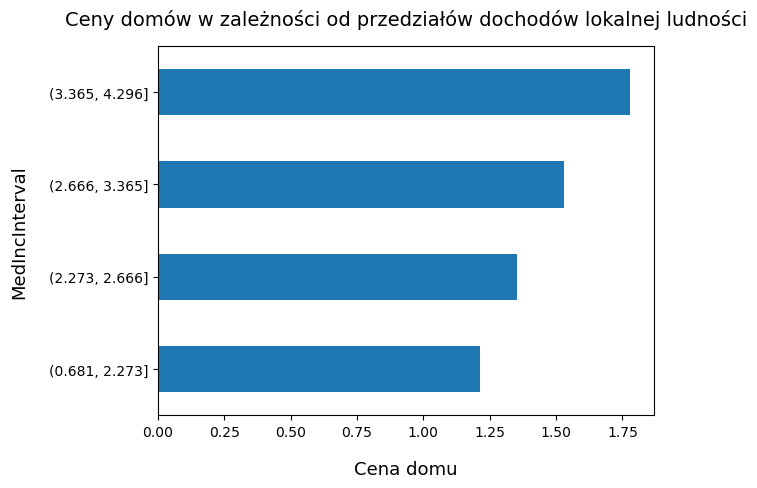

In [90]:
trainset.groupby('MedIncInterval')['MedHouseVal'].mean().plot.barh()
plt.title('Ceny domów w zależności od przedziałów dochodów lokalnej ludności', pad = 15, fontsize = 14)
plt.ylabel('MedIncInterval', labelpad = 15, fontsize = 13)
plt.xlabel('Cena domu', labelpad = 15, fontsize = 13)
plt.show()

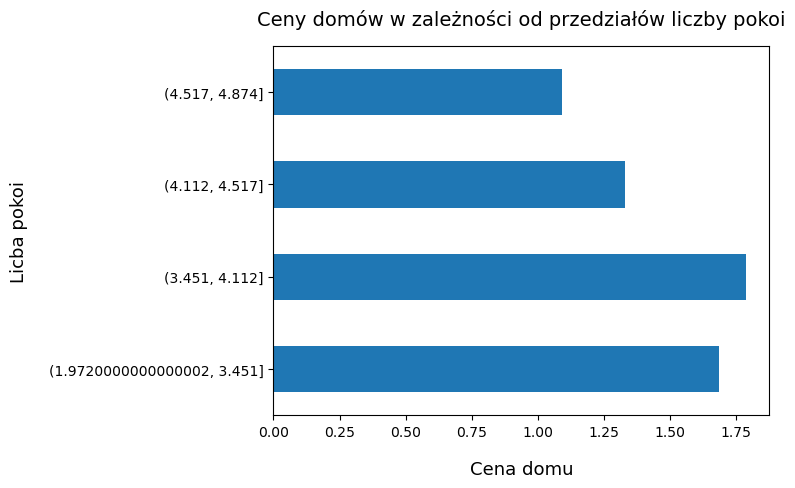

In [91]:
trainset['AveRoomsInterval'] = pd.qcut( trainset['AveRooms'], q = 4).astype(str)


trainset.groupby('AveRoomsInterval')['MedHouseVal'].mean().plot.barh()
plt.title('Ceny domów w zależności od przedziałów liczby pokoi', pad = 15, fontsize = 14)
plt.ylabel('Licba pokoi', labelpad = 15, fontsize = 13)
plt.xlabel('Cena domu', labelpad = 15, fontsize = 13)
plt.show()

In [92]:
['MedInc','HouseAge', 'AveRooms', 'Latitude'] + ['MedHouseVal']

['MedInc', 'HouseAge', 'AveRooms', 'Latitude', 'MedHouseVal']

In [96]:
[1, 2] + [1, 1] # listy pythonowe wbudowane

[1, 2, 1, 1]

In [97]:
np.array([1, 2]) + np.array([1, 1]) # tablice numpy

array([2, 3])

In [94]:
# na podstawie korelacji i wykresow
zmienne_do_modelu = ['MedInc','HouseAge', 'AveRooms', 'Latitude']

trainset_selected = trainset[zmienne_do_modelu + ['MedHouseVal']]
testset_selected = testset[zmienne_do_modelu + ['MedHouseVal']]

In [141]:
scaler = StandardScaler()
trainset_selected_scaled = pd.DataFrame( scaler.fit_transform(trainset_selected), columns = trainset_selected.columns )

# na testowym transform a nie fit transform!
testset_selected_scaled = pd.DataFrame( scaler.transform(testset_selected), columns = testset_selected.columns ) 

In [142]:
trainset_selected_scaled.head()

,MedInc,HouseAge,AveRooms,Latitude,MedHouseVal
0,-0.478723,-0.602692,0.741728,1.091126,-0.234586
1,0.256857,1.353414,0.424744,0.812861,1.094818
2,1.246519,-1.254727,-1.081248,0.547846,1.382627
3,-0.341789,0.831786,-2.288708,-1.638524,0.640833
4,1.481779,-0.863506,1.251119,-0.114690,-1.082594


In [144]:
trainset_selected_scaled.describe().round(2)

,MedInc,HouseAge,AveRooms,Latitude,MedHouseVal
count,74.00,74.00,74.00,74.00,74.00
mean,0.00,0.00,-0.00,-0.00,0.00
std,1.01,1.01,1.01,1.01,1.01
min,-2.43,-2.04,-2.68,-1.82,-1.62
25%,-0.51,-0.60,-0.67,-0.98,-0.94
50%,-0.04,-0.08,0.22,0.22,-0.05
75%,0.81,0.96,0.77,0.79,0.85
max,1.93,1.48,1.25,1.20,1.96


In [98]:
testset_selected.head(2)

,MedInc,HouseAge,AveRooms,Latitude,MedHouseVal
9070,1.1917,32.0,4.311111,34.71,0.869
5050,0.8702,11.0,3.717262,34.02,1.705


In [99]:
X_train = trainset_selected.drop('MedHouseVal', axis = 1)
y_train = trainset_selected['MedHouseVal']

X_test = testset_selected.drop('MedHouseVal', axis = 1)
y_test = testset_selected['MedHouseVal']

## Baseline model

In [104]:
ridge = Ridge()
ridge.fit(X_train, y_train)
train_ridge_preds = ridge.predict(X_train)
test_ridge_preds = ridge.predict(X_test)

err_train = mean_absolute_error(y_train, train_ridge_preds)
err_test = mean_absolute_error(y_test, test_ridge_preds)

print("Średni błąd bezwzględny na zbiorze treningowym jest {} a na testowym {}".format(err_train, err_test))


Średni błąd bezwzględny na zbiorze treningowym jest 0.3533868513697937 a na testowym 0.4027547978419799


In [108]:
def perform_randomized_grid_search(X_train, y_train, algorithm, param_distributions, n_iter=100, cv=5, scoring='accuracy',\
                                   random_state=42, debug=False, verbose = 0):
    """
    Perform a randomized grid search to find the best hyperparameters for a given algorithm.

    Parameters:
    algorithm (estimator): The machine learning algorithm to optimize.
    param_distributions (dict): The parameter distributions to sample from during the search.
    n_iter (int): Number of parameter settings that are sampled. Defaults to 100.
    cv (int): Number of cross-validation folds. Defaults to 5.
    scoring (str): The metric to optimize. Defaults to 'accuracy'.
    random_state (int): Random seed for reproducibility. Defaults to 42.

    Returns:
    best_estimator (estimator): The best estimator found by the search.
    best_score (float): The best score achieved by the best estimator.
    best_params (dict): The best hyperparameters found by the search.

    Example:
    param_distributions = {
     'n_estimators': [100, 200, 300, 400, 500],
     'max_features': ['auto', 'sqrt', 'log2'],
     'max_depth': [None, 10, 20, 30, 40, 50],
     'min_samples_split': [2, 5, 10],
     'min_samples_leaf': [1, 2, 4]
        }
    
    best_estimator, best_score, best_params = perform_randomized_grid_search(X_train, y_train, RandomForestClassifier(), param_distributions)
    
    print("Best Estimator:", best_estimator)
    print("Best Score:", best_score)
    print("Best Parameters:", best_params)

    Best Estimator: RandomForestClassifier(max_depth=40, max_features='log2', n_estimators=200)
    Best Score: 0.9926412487912696
    Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 40}
    """
    # Initialize the RandomizedSearchCV object
    randomized_search = RandomizedSearchCV(
        estimator=algorithm,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        random_state=random_state,
        n_jobs=-1,
        verbose=verbose

    )

    # Fit the randomized search to the data
    randomized_search.fit(X_train, y_train)

    # Get the best estimator, score, and parameters
    best_estimator = randomized_search.best_estimator_
    best_score = randomized_search.best_score_
    best_params = randomized_search.best_params_

    if debug :
        debug_results = pd.DataFrame(randomized_search.cv_results_)

        return debug_results

    return best_estimator, best_score, best_params

In [109]:
rf_grid = {
     'n_estimators': [100, 200, 300, 400],
     'max_features': ['auto', 'sqrt', 'log2'],
     'max_depth': [None, 3, 5, 10, 20, 30 ],
     'min_samples_split': [2, 5, 10, 20, 40],
     'min_samples_leaf': [2, 4, 16, 64]
 }

ridge_grid = { 'alpha' :  list(np.linspace(0.01, 2, 200)) }

In [111]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [113]:
ridge_estimator, ridge_score, ridge_params = perform_randomized_grid_search(X_train, y_train, Ridge(), ridge_grid, scoring = "neg_mean_absolute_error", n_iter = 75)

print("Best Estimator:", ridge_estimator, "\n")
print("Best Score:", ridge_score, "\n")
print("Best Parameters:", ridge_params, "\n")

Best Estimator: Ridge(alpha=0.060000000000000005) 

Best Score: -0.37507674416215486 

Best Parameters: {'alpha': 0.060000000000000005} 



In [114]:
rf_estimator, rf_score, rf_params = perform_randomized_grid_search(X_train, y_train, RandomForestRegressor(random_state=123), rf_grid, scoring = "neg_mean_absolute_error", n_iter = 40)

print("Best Estimator:", rf_estimator, "\n")
print("Best Score:", rf_score, "\n")
print("Best Parameters:", rf_params, "\n")

Best Estimator: RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                      random_state=123) 

Best Score: -0.34827894217480926 

Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20} 



In [121]:
gb_grid = {
     'n_estimators': [100, 200, 300, 400],
     'max_features': ['auto', 'sqrt', 'log2'],
     'max_depth': [2, 3, 5 ],
     'min_samples_split': [10, 15, 20, 25, 40],
     'min_samples_leaf': [16, 32, 64],
    'learning_rate' : [0.05, 0.1, 0.15]
 }

In [122]:
gb_estimator, gb_score, gb_params = perform_randomized_grid_search(X_train, y_train, GradientBoostingRegressor(random_state=123), gb_grid, scoring = "neg_mean_absolute_error", n_iter = 75)

print("Best Estimator:", gb_estimator, "\n")
print("Best Score:", gb_score, "\n")
print("Best Parameters:", gb_params, "\n")

Best Estimator: GradientBoostingRegressor(max_features='sqrt', min_samples_leaf=16,
                          min_samples_split=40, n_estimators=300,
                          random_state=123) 

Best Score: -0.317227980866847 

Best Parameters: {'n_estimators': 300, 'min_samples_split': 40, 'min_samples_leaf': 16, 'max_features': 'sqrt', 'max_depth': 3, 'learning_rate': 0.1} 



In [128]:
final_preds =  gb_estimator.predict(X_test) 
final_preds_train = gb_estimator.predict(X_train)

err_train_gb = mean_absolute_error(y_train, final_preds_train)
err_test_gb = mean_absolute_error(y_test, final_preds)


print("Średni błąd bezwzględny ztuningowanego GradientBoostingRegressor na zbiorze treningowym jest {} a na testowym {}"\
      .format(err_train_gb, err_test_gb))

Średni błąd bezwzględny ztuningowanego GradientBoostingRegressor na zbiorze treningowym jest 0.15382041896272447 a na testowym 0.36242060805050086


In [133]:
def feature_importance( model, index, target_variable, perm_imp = False, X_val = None, y_val = None, fig_size_tup=(10, 6), n=10,
                       full_table=False, ascending=False, random_state=0, n_repeats=30):
    """
    Returns the feature importances in the form of a table or a grouped bar chart.

    Parameters
    ----------
    model : fitted sklearn tree-based model such as Decision Tree or Random Forest.
    index : list of strings
        The features the model was trained with.
    target_variable : str
        The name of the target variable to be included in the title of the plot.
        Relevant only if full_table = False.
    perm_imp : bool
        Whether to compute permutation importances.
        Defaults to False.
    X_val : pd.DataFrame
        Validation / test features.
        Defaults to None.
        Relevant only if perm_imp = True.
    y_val : pd.Series or np.array
        Validation / test target values.
        Defaults to None.
        Relevant only if perm_imp = True.
    fig_size_tup : tuple
        The size of the plot. Relevant only if full_table = False.
        Defaults to (10, 6).
    n : int
        Number of variables to display on feature importances plot.
        Relevant only if full_table = False.
        Defaults to 10.
    full_table : bool
        Whether to return a full table of importances or plot a chart.
        Defaults to False.
    ascending : bool
        Sort order of feature importances.
        Defaults to False.
    random_state : int
        Random state for reproducibility.
        Defaults to 0.
    n_repeats : int
        Number of repeats for permutation importance.
        Defaults to 30.

    Returns
    -------
    None if full_table = False (Displays the plot).
    pandas.DataFrame if full_table = True (Feature importances table).
    """

    # Compute impurity-based importances
    try:
        impurity_importances = pd.DataFrame(model.feature_importances_,
                                            index=index, columns=['Impurity Importance'])
    except AttributeError:
        print("Skipping impurity importance as the provided model does not have the 'feature_importances_' attribute .")
        impurity_importances = None

    if perm_imp :
        # Compute permutation importances
        perm_imp_result = permutation_importance(model, X_val, y_val, n_repeats=n_repeats, random_state=random_state)
        perm_importances = pd.DataFrame(perm_imp_result['importances_mean'], index=index, columns=['Permutation Importance'])
        
        if impurity_importances is None:
            feature_importances =  perm_importances.sort_values('Permutation Importance', ascending=ascending)
        else :
            # Combine both importance metrics
            feature_importances = pd.concat([impurity_importances, perm_importances], axis=1)
            feature_importances = feature_importances\
                .sort_values('Permutation Importance', ascending=ascending) [ [ 'Permutation Importance', 'Impurity Importance' ] ]
    else :        
        feature_importances = impurity_importances.sort_values('Impurity Importance', ascending=ascending)

    if full_table:
        return feature_importances 

    # Prepare for plotting
    top_features = feature_importances.head(n)

    color_mapping = {'Impurity Importance': 'lightcoral', 'Permutation Importance': 'red'}
    colors = [color_mapping[col] for col in top_features.columns]

    #[ 'lightcoral', 'red' ]
    # Plot grouped bar chart
    ax = top_features.plot( kind='bar', figsize=fig_size_tup, rot = 70, color = colors  )
    ax.set_title( f'Importances of different variables affecting {target_variable}', fontsize=15, pad=15 )
    ax.set_ylabel( "Importance", fontsize=13, labelpad=14 )
    ax.set_xlabel( "Feature", fontsize=13, labelpad=14 )
    ax.legend( title="Importance Type" )
    ax.grid( axis="y" )
    
    return None


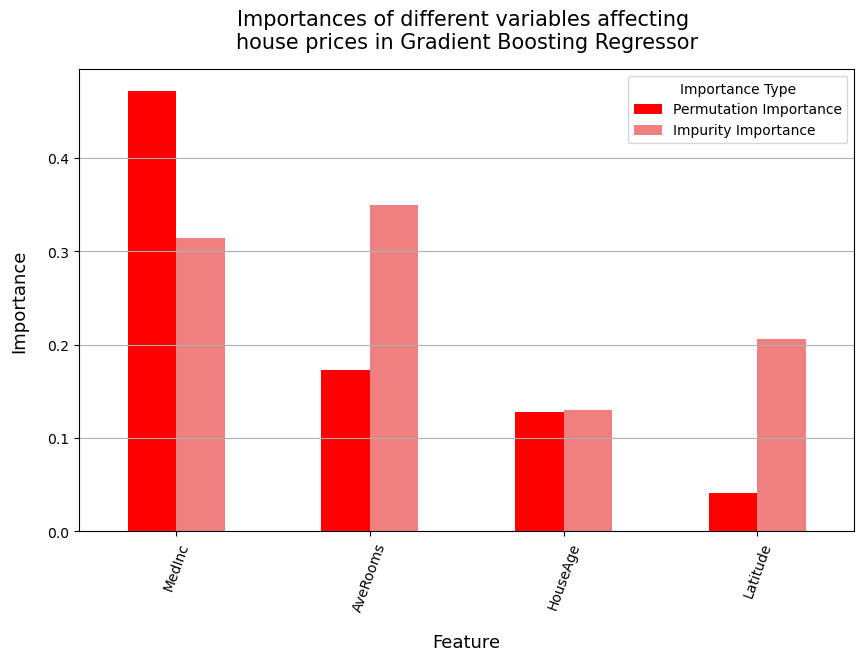

In [134]:
feature_importance( gb_estimator, X_train.columns, '\nhouse prices in Gradient Boosting Regressor', perm_imp = True, X_val = X_test, y_val = y_test, n = 5 )

Skipping impurity importance as the provided model does not have the 'feature_importances_' attribute .


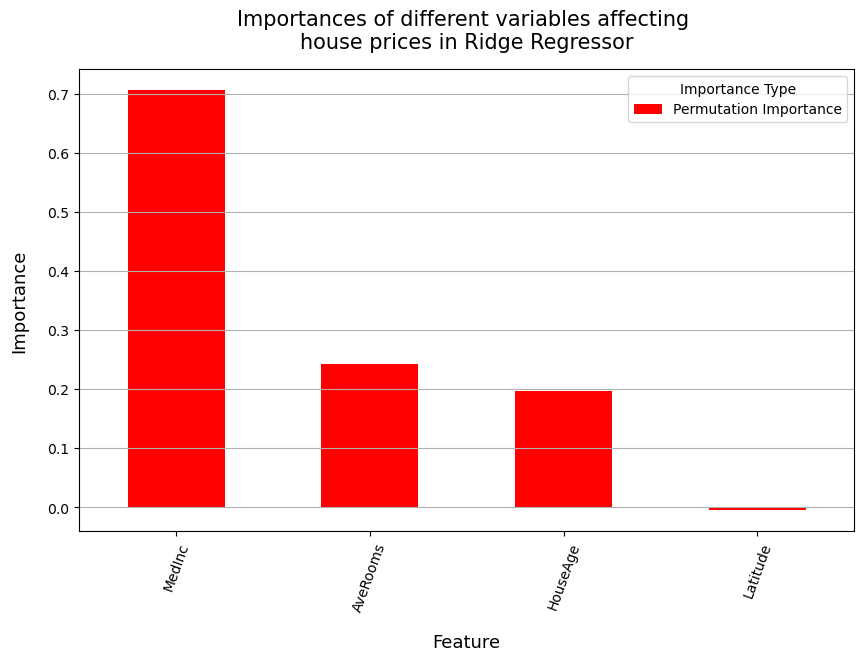

In [135]:
feature_importance( ridge_estimator, X_train.columns, '\nhouse prices in Ridge Regressor', perm_imp = True, X_val = X_test, y_val = y_test, n = 5 )